In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

### Load Pre-Split Train/Val/Test Data

In [13]:
# Load pre-split train/val/test datasets
Dir = 'data/2024_08/'

X_train = pd.read_csv(Dir + 'X_train.csv')
X_val = pd.read_csv(Dir + 'X_val.csv')
X_test = pd.read_csv(Dir + 'X_test.csv')

y_train = pd.read_csv(Dir + 'y_train.csv')
y_val = pd.read_csv(Dir + 'y_val.csv')
y_test = pd.read_csv(Dir + 'y_test.csv')

# Convert y dataframes to series
y_train = y_train['cumulative_bikes']
y_val = y_val['cumulative_bikes']
y_test = y_test['cumulative_bikes']

print("Loaded pre-split datasets:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  y_test:  {y_test.shape}")

print(f"\nFeatures in dataset: {X_train.shape[1]}")

Loaded pre-split datasets:
  X_train: (104621, 26)
  X_val:   (34874, 26)
  X_test:  (34874, 26)
  y_train: (104621,)
  y_val:   (34874,)
  y_test:  (34874,)

Features in dataset: 26


In [14]:
# Remove data leakage features

LEAKAGE_COLUMNS = [
    'rate_of_change',  
    'rate_of_change_lag1',
    'rolling_mean_4', 
    'rolling_std_4',  
]

# Check which leakage columns exist
existing_leakage = [col for col in LEAKAGE_COLUMNS if col in X_train.columns]

if existing_leakage:
    print(f"Found {len(existing_leakage)} leakage columns to remove:")
    for col in existing_leakage:
        print(f"  - {col}")
    
    # Remove from all datasets
    X_train = X_train.drop(columns=existing_leakage)
    X_val = X_val.drop(columns=existing_leakage)
    X_test = X_test.drop(columns=existing_leakage)
    
    print(f"\n✅ Removed {len(existing_leakage)} leakage columns")
else:
    print("✅ No leakage columns found in dataset")

print(f"✅ Final feature count: {X_train.shape[1]}")

print(f"\nFeatures being used ({X_train.shape[1]} total):")
for i, col in enumerate(X_train.columns, 1):
    print(f"  {i:2}. {col}")

Found 4 leakage columns to remove:
  - rate_of_change
  - rate_of_change_lag1
  - rolling_mean_4
  - rolling_std_4

✅ Removed 4 leakage columns
✅ Final feature count: 22

Features being used (22 total):
   1. hour
   2. day_of_week
   3. is_morning_rush
   4. is_evening_rush
   5. avg_trip_duration
   6. median_trip_duration
   7. electric_bike_count
   8. member_count
   9. lat
  10. lng
  11. borough_encoded
  12. distance_from_center
  13. total_historical_rides
  14. avg_trip_duration_hist
  15. std_trip_duration
  16. member_proportion_hist
  17. temp
  18. windspeed
  19. is_raining
  20. classic_bike_count
  21. casual_count
  22. borough_manhattan


### Baseline Models

In [15]:
# Baseline Random Forest Model
print("="*60)
print("BASELINE RANDOM FOREST")
print("="*60)

rf_baseline = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

print("\nTraining baseline Random Forest...")
rf_baseline.fit(X_train, y_train)

# Predictions
y_pred_rf_baseline_val = rf_baseline.predict(X_val)
y_pred_rf_baseline_test = rf_baseline.predict(X_test)

# Calculate metrics
rf_baseline_rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_rf_baseline_val))
rf_baseline_mae_val = mean_absolute_error(y_val, y_pred_rf_baseline_val)
rf_baseline_r2_val = r2_score(y_val, y_pred_rf_baseline_val)

rf_baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_baseline_test))
rf_baseline_mae = mean_absolute_error(y_test, y_pred_rf_baseline_test)
rf_baseline_r2 = r2_score(y_test, y_pred_rf_baseline_test)

print("\nValidation Set:")
print(f"  RMSE: {rf_baseline_rmse_val:.2f}")
print(f"  MAE:  {rf_baseline_mae_val:.2f}")
print(f"  R²:   {rf_baseline_r2_val:.4f}")

print("\nTest Set:")
print(f"  RMSE: {rf_baseline_rmse:.2f}")
print(f"  MAE:  {rf_baseline_mae:.2f}")
print(f"  R²:   {rf_baseline_r2:.4f}")

BASELINE RANDOM FOREST

Training baseline Random Forest...

Validation Set:
  RMSE: 9.27
  MAE:  6.07
  R²:   0.5058

Test Set:
  RMSE: 9.16
  MAE:  5.94
  R²:   0.5538


In [16]:
# Baseline XGBoost Model
print("="*60)
print("BASELINE XGBOOST")
print("="*60)

xgb_baseline = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("\nTraining baseline XGBoost...")
xgb_baseline.fit(X_train, y_train)

# Predictions
y_pred_xgb_baseline_val = xgb_baseline.predict(X_val)
y_pred_xgb_baseline_test = xgb_baseline.predict(X_test)

# Calculate metrics
xgb_baseline_rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_xgb_baseline_val))
xgb_baseline_mae_val = mean_absolute_error(y_val, y_pred_xgb_baseline_val)
xgb_baseline_r2_val = r2_score(y_val, y_pred_xgb_baseline_val)

xgb_baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_baseline_test))
xgb_baseline_mae = mean_absolute_error(y_test, y_pred_xgb_baseline_test)
xgb_baseline_r2 = r2_score(y_test, y_pred_xgb_baseline_test)

print("\nValidation Set:")
print(f"  RMSE: {xgb_baseline_rmse_val:.2f}")
print(f"  MAE:  {xgb_baseline_mae_val:.2f}")
print(f"  R²:   {xgb_baseline_r2_val:.4f}")

print("\nTest Set:")
print(f"  RMSE: {xgb_baseline_rmse:.2f}")
print(f"  MAE:  {xgb_baseline_mae:.2f}")
print(f"  R²:   {xgb_baseline_r2:.4f}")

BASELINE XGBOOST

Training baseline XGBoost...

Validation Set:
  RMSE: 9.13
  MAE:  6.12
  R²:   0.5207

Test Set:
  RMSE: 9.13
  MAE:  6.13
  R²:   0.5568


### Grid Search for Hyperparameter Tuning

In [17]:
# Random Forest Grid Search
print("="*60)
print("RANDOM FOREST GRID SEARCH")
print("="*60)

# Define a small parameter grid (limited to keep runtime under 2-3 minutes)
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [15, 20],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [4, 8]
}

# Initialize base model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid search with 3-fold CV (faster than 5-fold)
rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print(f"\nSearching {len(rf_param_grid['n_estimators']) * len(rf_param_grid['max_depth']) * len(rf_param_grid['min_samples_split']) * len(rf_param_grid['min_samples_leaf'])} parameter combinations...")
print("This should take 2-3 minutes...\n")

# Fit grid search
rf_grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("BEST RANDOM FOREST PARAMETERS")
print("="*60)
print(rf_grid_search.best_params_)

# Use best model
rf_model = rf_grid_search.best_estimator_

# Predictions on validation and test sets
y_pred_rf_val = rf_model.predict(X_val)
y_pred_rf_test = rf_model.predict(X_test)

# Calculate metrics for validation set
rf_rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_rf_val))
rf_mae_val = mean_absolute_error(y_val, y_pred_rf_val)
rf_r2_val = r2_score(y_val, y_pred_rf_val)

# Calculate metrics for test set
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
rf_mae = mean_absolute_error(y_test, y_pred_rf_test)
rf_r2 = r2_score(y_test, y_pred_rf_test)

print("\n" + "="*60)
print("RANDOM FOREST RESULTS (TUNED)")
print("="*60)
print(f"Validation Set:")
print(f"  RMSE: {rf_rmse_val:.2f}")
print(f"  MAE:  {rf_mae_val:.2f}")
print(f"  R²:   {rf_r2_val:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  MAE:  {rf_mae:.2f}")
print(f"  R²:   {rf_r2:.4f}")

RANDOM FOREST GRID SEARCH

Searching 16 parameter combinations...
This should take 2-3 minutes...

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=  18.0s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=  18.1s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=  18.2s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=20, n_estimators=50; total time=  19.1s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=20, n_estimators=50; total time=  18.9s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=20, n_estimators=50; total time=  19.1s
[CV] END max_depth=15, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=  19.3s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  38.2s
[CV] END max_depth=15, min_samp

In [19]:
# XGBoost Grid Search
print("="*60)
print("XGBOOST GRID SEARCH")
print("="*60)

# Define a small parameter grid (limited to keep runtime under 2-3 minutes)
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize base model
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Grid search with 3-fold CV
xgb_grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print(f"\nSearching {len(xgb_param_grid['n_estimators']) * len(xgb_param_grid['max_depth']) * len(xgb_param_grid['learning_rate']) * len(xgb_param_grid['subsample'])} parameter combinations...")
print("This should take 2-3 minutes...\n")

# Fit grid search
xgb_grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("BEST XGBOOST PARAMETERS")
print("="*60)
print(xgb_grid_search.best_params_)

# Use best model
xgb_model = xgb_grid_search.best_estimator_

# Predictions on validation and test sets
y_pred_xgb_val = xgb_model.predict(X_val)
y_pred_xgb_test = xgb_model.predict(X_test)

# Calculate metrics for validation set
xgb_rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_xgb_val))
xgb_mae_val = mean_absolute_error(y_val, y_pred_xgb_val)
xgb_r2_val = r2_score(y_val, y_pred_xgb_val)

# Calculate metrics for test set
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb_test)
xgb_r2 = r2_score(y_test, y_pred_xgb_test)

print("\n" + "="*60)
print("XGBOOST RESULTS (TUNED)")
print("="*60)
print(f"Validation Set:")
print(f"  RMSE: {xgb_rmse_val:.2f}")
print(f"  MAE:  {xgb_mae_val:.2f}")
print(f"  R²:   {xgb_r2_val:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {xgb_rmse:.2f}")
print(f"  MAE:  {xgb_mae:.2f}")
print(f"  R²:   {xgb_r2:.4f}")

XGBOOST GRID SEARCH

Searching 16 parameter combinations...
This should take 2-3 minutes...

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END learning_rate=0.05, max_depth=4, n_estimators=50, subsample=1.0; total time=   3.0s
[CV] END learning_rate=0.05, max_depth=4, n_estimators=50, subsample=1.0; total time=   3.0s
[CV] END learning_rate=0.05, max_depth=4, n_estimators=50, subsample=1.0; total time=   3.0s
[CV] END learning_rate=0.05, max_depth=4, n_estimators=50, subsample=0.8; total time=   3.3s
[CV] END learning_rate=0.05, max_depth=4, n_estimators=50, subsample=0.8; total time=   3.4s
[CV] END learning_rate=0.05, max_depth=4, n_estimators=50, subsample=0.8; total time=   3.4s
[CV] END learning_rate=0.05, max_depth=4, n_estimators=100, subsample=1.0; total time=   5.7s
[CV] END learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.8; total time=   6.4s
[CV] END learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.8; total time=   6.6s
[CV] E

### Model Comparison (Tuned Models)


MODEL COMPARISON (TUNED MODELS)
                Model     RMSE      MAE       R²
Random Forest (Tuned) 9.148371 5.969076 0.554817
      XGBoost (Tuned) 9.157880 6.144568 0.553891


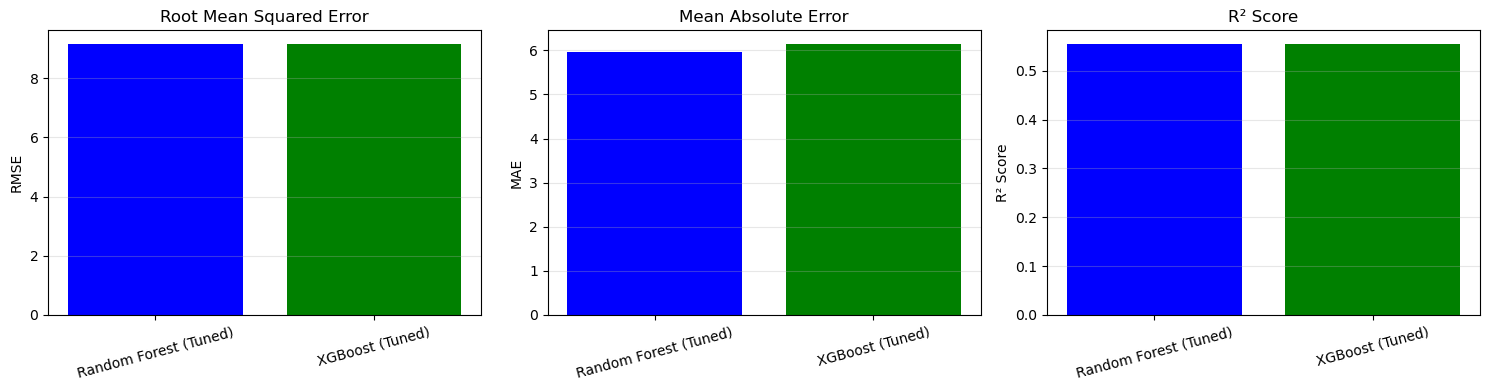

In [18]:
# Compare Tuned Models

results = pd.DataFrame({
    'Model': ['Random Forest (Tuned)', 'XGBoost (Tuned)'],
    'RMSE': [rf_rmse, xgb_rmse],
    'MAE': [rf_mae, xgb_mae],
    'R²': [rf_r2, xgb_r2]
})

print("\n" + "="*50)
print("MODEL COMPARISON (TUNED MODELS)")
print("="*50)
print(results.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# RMSE comparison
axes[0].bar(results['Model'], results['RMSE'], color=['blue', 'green'])
axes[0].set_ylabel('RMSE')
axes[0].set_title('Root Mean Squared Error')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)

# MAE comparison
axes[1].bar(results['Model'], results['MAE'], color=['blue', 'green'])
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

# R squared comparison
axes[2].bar(results['Model'], results['R²'], color=['blue', 'green'])
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Score')
axes[2].grid(axis='y', alpha=0.3)
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

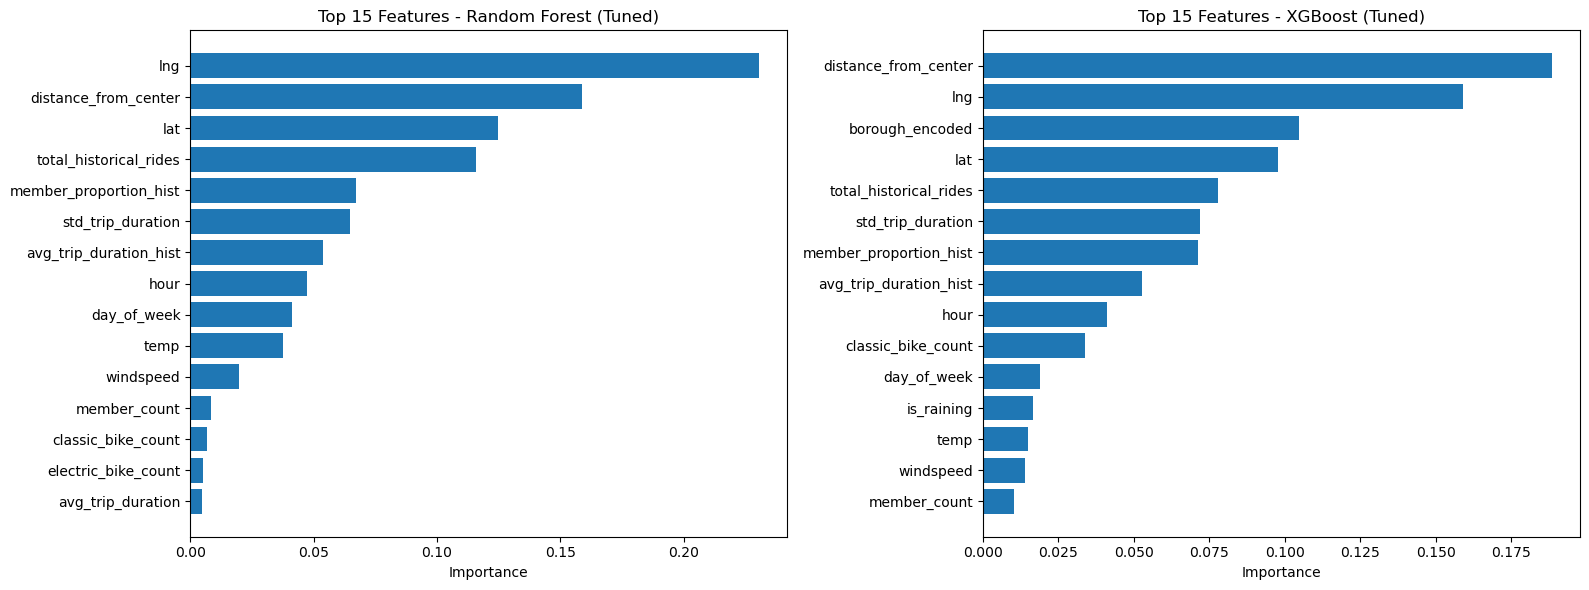

In [20]:
# Feature Importance Analysis (Tuned Models)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0].barh(range(len(rf_importance)), rf_importance['importance'])
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 15 Features - Random Forest (Tuned)')
axes[0].invert_yaxis()

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(range(len(xgb_importance)), xgb_importance['importance'])
axes[1].set_yticks(range(len(xgb_importance)))
axes[1].set_yticklabels(xgb_importance['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 15 Features - XGBoost (Tuned)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()